### Hannah's Week 3 Objective:
*    If the epithelium is disjoint (>1 contour found) then patches are only taken from 1 contour - Hannah

#### Approach
Explore openCV's built-in contour hierarchy object (returned from `cv2.findContours()`) and develop a generalizeable logic for selecting appropriate contours (which contain the epithelium). See annotated image below for more detailed explanation of this function's hierarchy logic.

From inspection of the slices we've used for testing thus far, the epithelia we want to patch fall broadly into being 'donut'-shaped or 'island'-shaped. Donut shapes are epithelia from slices which contain a significant region of the stroma within the epithelia, which surrounds the stroma. This creates a primary outer contour for the epithelium and a secondary inner contour we want to discard. See `testing_slices/h2114153  h&e_ROI_1 Epithelia.png` for an example. The other example we've seen are epithelia which are split into islands - these are chunks of epithelia with no stroma found inside and also not nested within a larger structure in the image. See `testing_slices/h2114154  h&e_ROI_4 Epithelia.png` for an example. 

Translated into the hierarchy logic used by cv2:
* Donuts are contours which have a single child with no siblings
* Islands are contours which have neither a parent nor children

The `hierarchy` object returned by `cv2.find_contours()` is a three-dimensional array, so `hierarchy[0]` accesses the dimension of the hierarchy containing the hierarchy designation of each contour. The code below loops through each contour of the hierarchy, so `hierarchy[0][idx]` returns the 4-element hierarchy object for the specific contour specified by `idx`. 

Lastly `hierarchy[0][idx][0-3]` returns the specific values for the contour's next, previous, child, and parent, where:
* `hierarchy[0][idx][0]` = next
* `hierarchy[0][idx][1]` = prev
* `hierarchy[0][idx][2]` = child
* `hierarchy[0][idx][3]` = parent

> hierarchy

[[[int, int, int, int]
  [int, int, int, int]]]


> hierarchy[0]

[[[next_1, prev_1, child_1, parent_1]
  [next_2, prev_2, child_2, parent_2]]]


> hierarchy[0][idx], let idx = 0 in this case:

[next_1, prev_1, child_1, parent_1]


> hierarchy[0][idx][0]

next_1

Checking `hierarchy[0][child][0] == -1` and `hierarchy[0][child][1] == -1` in the case of 'donut'-type slices ensures that there is only one inner contour. A value of `-1` in the last bracket indicates that object does not exist, so the code in the previous sentence indicates that this contour has no 'next' or 'prev' object - that they have no "siblings" which reside in the same level of the hierarchy.

![Annotated example tissue hierarchy](.ipynb_checkpoints/cv2_hierarchy_img.jpg)

#### Relevant Modifications
* get_new_imgs - Packages up Ryan's original image preprocessing code into a callable function
* find_contours - Implements hierarchy logic - bulk of work for week
* draw_contours - Function to draw selected contours for visualization and debugging

In [1]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

#Read image and threshold for mask:
#This basic method works best with already cropped cells
#I have another at the bottom that is slightly better for cells with backgrounds

def get_new_imgs(file_path):
    image1=cv2.imread(file_path)
    padding_size = 500
    height, width = image1.shape[:2]
    new_height = height + 2 * padding_size
    new_width = width + 2 * padding_size

    new_image = np.zeros((new_height, new_width, 3), dtype=np.uint8)
    new_image[padding_size:padding_size+height, padding_size:padding_size+width] = image1

    image1_gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
    _,whole_thresh=cv2.threshold(image1_gray,1,255,cv2.THRESH_BINARY)

    return new_image, whole_thresh

In [6]:
def find_contours(binary_image):
    '''find relevant contours of an image'''
    contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    valid_contours = []
    # loop through all found contours for donuts and islands
    for idx, contour in enumerate(contours):
        child = hierarchy[0][idx][2]
        parent = hierarchy[0][idx][3]
        if child != -1 and hierarchy[0][child][0] == -1 and hierarchy[0][child][1] == -1: # donut
            valid_contours.append(contour)
        elif child == -1 and parent == -1: # island (no parents or children)
            valid_contours.append(contour)
    # check to make sure contours meet size threshold        
    valid_contours_size_check = [contour for contour in contours if cv2.contourArea(contour) > 30000]        
            
    return tuple(valid_contours_size_check)

def draw_contours(binary_image):
    contours = find_contours(binary_image)
    all_points = [[0, 0]]
    #Loop over all contours in image and ershape into xy pairings
    for contour in contours:
        points = np.array(contour.reshape(-1,2))
        all_points = np.concatenate((all_points, points))
    # draw contour points over image of tissue slice
    plt.imshow(binary_image, aspect='equal')
    plt.scatter(np.array(all_points)[:,0], np.array(all_points)[:,1], c='red', marker='o', s = 1)
    plt.show()

Code in the cell below is borrowed directly from Ryan's 'Normal Squares Toggleable' notebook with no modifications.

In [3]:
def calculate_contour_normals(contours,smoothing_size=5):
    '''Calculate normal vector along contour points'''

    all_normals=[]
    
    #Loop over all contours in image
    for contour in contours:
        #Reshape into xy pairings
        points=contour.reshape(-1,2)
        n_points=len(points)
        tangents=np.zeros_like(points,dtype=float)

        #Calculate tangent using smoothing
        for i in range(n_points):
            prev_idx=(i-smoothing_size)%n_points
            next_idx=(i+smoothing_size)%n_points
            tangent=points[next_idx]-points[prev_idx]
            tangent=tangent/(np.linalg.norm(tangent)+1e-8)
            tangents[i]=tangent
            

        #Convert to normal
        normals=np.zeros_like(tangents)
        normals[:,0]=-tangents[:,1]
        normals[:,1]=tangents[:,0]
        
        #add to list of all contour normals
        all_normals.append(normals)

    return all_normals

def calculate_square_corners(point,normal,square_size,binary_image,variable_length=True):
    '''Calculate corners of square normal to point'''

    tangent=np.array([-normal[1],normal[0]])
    half_size=square_size//2
    extended_length=square_size

    #Loop to find variable length
    if variable_length:
        i=square_size
        while True:
            #Increase i while extending into cell
            test_point=point-(normal*i).astype(int)
            test_point=np.clip(test_point,0,np.array(binary_image.shape[:2])[::-1] - 1)

            if binary_image[test_point[1],test_point[0]]==0:
                break
            #if i>=1024:
            #    break #Maximum square size as to not be huge
            i+=2

        extended_length=i
        half_size=i//2

    corners = np.array([
        point + (tangent * half_size),
        point - (tangent * half_size),
        point - (tangent * half_size) - (normal * extended_length),
        point + (tangent * half_size) - (normal * extended_length)
    ])

    return corners, extended_length

def calculate_square_overlap(square1,square2):
    '''Calculate overlap ratio between squares'''

    square1=Polygon(square1)
    square2=Polygon(square2)

    if not square1.intersects(square2):
        return 0
    
    intersection_area=square1.intersection(square2).area
    smallest_area=min(square1.area,square2.area)
    return intersection_area/smallest_area

def create_dense_squares(contours,normals,binary_image,square_size=128,step=5,variable_length=True):
    '''Create many squares along external contours at regular interval'''

    all_squares=[]


    #Loop over all contours 
    for contour,contour_normals in zip(contours, normals):
        points=contour.reshape(-1,2)
        n_points=len(points)
        squares=[]

        #Find corners at step length
        for i in range(0,n_points,step):
            corners,length=calculate_square_corners(points[i],contour_normals[i],square_size,binary_image,variable_length)

            if length>=2048 or length<16: #Trying to avoid badly sized squares
                continue

            squares.append(corners)

        all_squares.append(squares)
    return all_squares

def remove_overlapping_squares(all_squares, overlap_thresh=0.3, look_back=5, second_pass=True):
    final_squares_list = []

    # First pass: remove overlaps within each contour
    for squares in all_squares:
        # Keep first square
        kept_squares = [squares[0]]

        # Check squares within the same contour
        for i in range(1, len(squares)):
            overlap_found = False
            current_square = squares[i]

            # Check within look_back in same contour
            for j in range(max(0, len(kept_squares) - look_back), len(kept_squares)):
                overlap = calculate_square_overlap(current_square, kept_squares[j])
                if overlap > overlap_thresh:
                    overlap_found = True
                    break

            if not overlap_found:
                kept_squares.append(current_square)
        
        final_squares_list.append(kept_squares)

    # Second pass: check against ALL squares across ALL contours
    if second_pass:
        # Flatten all squares
        all_squares_flattened = [square for contour_squares in final_squares_list for square in contour_squares]
        final_refined_squares_list = []

        # Check each contour's squares
        for contour_squares in final_squares_list:
            refined_squares = []

            # Check each square against ALL other squares
            for square in contour_squares:
                overlap_found = False
                
                # Check against all flattened squares
                for other_square in all_squares_flattened:
                    if not np.array_equal(square, other_square):
                        overlap = calculate_square_overlap(square, other_square)
                        if overlap > overlap_thresh:
                            overlap_found = True
                            break
                
                # Only add if no significant overlap found
                if not overlap_found:
                    refined_squares.append(square)
            
            final_refined_squares_list.append(refined_squares)

        return final_refined_squares_list

    return final_squares_list

def draw_squares(image,squares_list,color=[255,0,0],thickness=20):
    '''Draw squares on image'''

    result=image.copy()

    for squares in squares_list:
        for square in squares:
            points=square.astype(np.int32)
            cv2.polylines(result,[points],isClosed=True,color=color,thickness=thickness)
        
    return result

def process_contours(image,binary_image,square_size=128,step=5,overlap_thresh=0.3,
                    smoothing_size=5,look_back=3,second_pass=True,variable_length=False):
    """
    Main function to process multiple contours and generate aligned squares along them.
    
    Args:
        image (np.ndarray): Original image
        binary_image (np.ndarray): Binary mask of the shapes
        square_size (int): Base size of squares
        step (int): Points to skip between squares
        overlap_thresh (float): Maximum allowed overlap between squares
        smoothing_size (int): Points to consider for normal calculation
        look_back (int): Squares to check for overlap
        second_pass (bool): Whether to do precise overlap checking
        variable_length (bool): Whether to use variable length squares
        
    Returns:
        tuple: (processed image, contours, squares_list)
    """
    contours=find_contours(binary_image)
    if not contours:
        return TypeError('No contours found')
    
    
    normals=calculate_contour_normals(contours,smoothing_size)
    squares_list=create_dense_squares(
        contours,normals,binary_image,
        square_size=square_size,
        step=step,
        variable_length=variable_length
    )
    
    final_squares_list=remove_overlapping_squares(
        squares_list,
        overlap_thresh=overlap_thresh,
        look_back=look_back,
        second_pass=second_pass
    )
    
    result = draw_squares(image,final_squares_list)
    plt.imshow(result)
    
    return result, contours, final_squares_list

Below is a depiction of a case for which the hierarchy logic for contour selection works well, alongside an image showing how patches are made for the tissue slice.

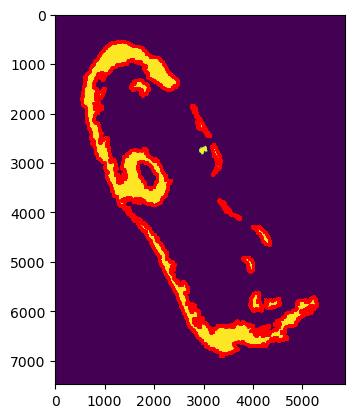

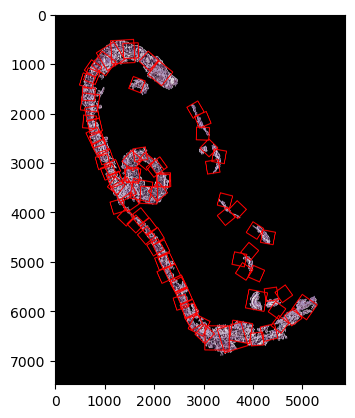

In [4]:
new_image, whole_thresh = get_new_imgs("testing_slices/h2114155 h&e_ROI_2 Epithelia.png") 
draw_contours(whole_thresh)
result_image, contour, squares = process_contours(
     new_image,
     whole_thresh,
     square_size=256,
     step=60,
     overlap_thresh=0.1,
     smoothing_size=200,
     look_back=5,
     second_pass=False,
     variable_length=True)

Below is an example where the hierarchy logic fails to capture the desired regions of the tissue. It is worth noting that due to the failed contour capturing, Ryan's patching code was also ultimately unable to run (took too long). Printing the hierarchy array returned by `cv2.find_contours` shows that the retrieval code is somehow identifying thousands of contours in the image rather than the 20-30 that are visible by eye. I'm willing to guess that the unusual number of contours is somehow generating unnecessary nested structures that cause certain contours to fail the donut and island tests.

In [15]:
contours, hierarchy = cv2.findContours(whole_thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
hierarchy

array([[[   1,   -1,   -1,   -1],
        [   2,    0,   -1,   -1],
        [   3,    1,   -1,   -1],
        ...,
        [4780, 4778,   -1, 1305],
        [4781, 4779,   -1, 1305],
        [  -1, 4780,   -1, 1305]]], dtype=int32)

The presence of duplicate unecessary contours is confirmed when all contours are drawn out:

In [11]:
new_image, whole_thresh = get_new_imgs("testing_slices/h2114155 h&e_ROI_4 Epithelia.png") 
def draw_contours(binary_image):
    contours, _ = cv2.findContours(whole_thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    #contours = contours[1:100]  # modification to plot only subset of contours
    all_points = [[0, 0]]
    #Loop over all contours in image and reshape into xy pairings
    for contour in contours:
        points = np.array(contour.reshape(-1,2))
        all_points = np.concatenate((all_points, points))
    # plot contour (x,y) points over tissue image
    plt.imshow(binary_image, aspect='equal')
    plt.scatter(np.array(all_points)[:,0], np.array(all_points)[:,1], c='red', marker='o', s = 1)
    plt.show
cv2.drawContours(whole_thresh, find_contours(whole_thresh), -1, (0,255,0), 3) 

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)